# COMP 1916 Data Mining for Business - Assessment

Credit card companies must accurately detect fraudulent transactions to protect customers from unauthorized charges. This dataset includes credit card transactions made by European cardholders in September 2013, covering two days of activity. Out of 284,807 transactions, only 492 were fraudulent, highlighting severe class imbalance, with fraud accounting for just 0.172% of all cases. All features, except "Time" and "Amount," are transformed via PCA, ensuring confidentiality. "Time" represents elapsed seconds since the first transaction, while "Amount" denotes the transaction value, valid for cost-sensitive learning. The "Class" target variable is binary, where 1 indicates fraud, and 0 signifies a legitimate transaction.

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pyod.models.knn import KNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import precision_recall_curve

2025-03-11 14:56:29.455600: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-11 14:56:29.773166: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-11 14:56:30.076032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741704990.307783    1655 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741704990.373661    1655 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 14:56:30.994950: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Data Preprocessing

Except for “Class,” which is saved as int64, the dataset information output verifies that every column contains float64 data types. With 284,807 non-null items in each column, no missing values indicate a clean dataset that does not require imputation. The PCA-transformed features have nearly zero means, which is compatible with standardization during transformation, as the summary statistics further demonstrate. With a mean of 88.35 and a maximum value of 25691.16, the “Amount” variable shows considerable variation, suggesting a highly skewed distribution.

The shape of the dataset is visible, verifying that there are 284,807 rows and 31 columns. The column names are retrieved by a different operation, which provides an organized list of all features. Lastly, missing value analysis ensures data completeness by confirming that no attributes contain null entries. Except for “Class,” which is still an integer, all values are saved as floating-point integers, establishing consistency in the data type output. These observations attest to the dataset's organization, numerical consistency among variables, and readiness for additional analytical processing.

In [12]:
# Load the dataset
df = pd.read_csv("creditcard 2.csv")

In [13]:
# Display the first few rows of the dataset
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [14]:
# Display dataset information (columns, non-null counts, data types)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [15]:
# Display summary statistics
print(df.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [16]:
# Display the shape of the dataset (number of rows and columns)
print("Dataset Shape:", df.shape)

Dataset Shape: (284807, 31)


In [17]:
# Display the column names
print("Column Names:", df.columns.tolist())

Column Names: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [18]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [19]:
# Display data types of each column
print("Data Types:\n", df.dtypes)

Data Types:
 Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


# Create representative sample

Using stratified sampling, 10% of the dataset has been extracted, preserving the original class distribution. Maintaining this proportion is essential to prevent bias and guarantee that infrequent fraudulent events are represented, especially considering the dataset's extreme imbalance, where fraudulent transactions make up just 0.1727% of all instances. The sampling procedure prevents a disproportionate reduction of the minority class by producing 28,431 non-fraudulent transactions and 49 fraudulent ones, which align with the overall distribution. This methodology guarantees that the features of the entire dataset will be reflected in any predictive modeling applied to the sample.

A thorough analysis of the summary statistics reveals essential details about the sampled dataset. The temporal consistency with the original dataset is maintained via the “Time” variable, which ranges from 0 to 172,768 seconds. With a mean of 86.76 and a maximum transaction value of 8,360, the “Amount” feature shows a highly skewed distribution, suggesting possible issues with the model's sensitivity to extreme values. Outliers may need to be standardized or transformed to lessen their impact on later analytical procedures.

The variance maximizing inherent in principle component analysis is reflected in the PCA-transformed variables ("V1" to "V28"), which maintain the predicted statistical characteristics with mean values near zero and variable standard deviations. This consistency guarantees the preservation of meaningful patterns and relationships by confirming that the dimensionality reduction process is still in place within the sampled dataset. These results provide a solid basis for additional exploratory and predictive research in fraud detection.

In [20]:
# Check class distribution in the original dataset
print("Original Class Distribution:\n", df["Class"].value_counts(normalize=True))

# Set sample size 
sample_size = 28480 #10% of the original data set

# Perform stratified sampling to maintain class proportions
df_sample, _ = train_test_split(df, train_size=sample_size, stratify=df["Class"], random_state=42)

# Check class distribution in the sampled dataset
print("Sampled Class Distribution:\n", df_sample["Class"].value_counts(normalize=True))

# Display the first few rows of the sampled dataset
print(df_sample.head())

Original Class Distribution:
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64
Sampled Class Distribution:
 Class
0    0.998279
1    0.001721
Name: proportion, dtype: float64
            Time        V1        V2        V3        V4        V5        V6  \
177282  123113.0 -4.168525 -4.164323  1.911850  1.130443  4.152041 -2.125948   
99433    67116.0 -0.241374 -0.043836  1.545847 -0.950404 -0.819948  0.847419   
182653  125495.0 -2.134432 -2.219310  0.969065 -2.858480  0.693123 -1.315593   
101035   67705.0 -0.862259 -0.224703  2.308340 -1.941343 -0.321210  1.954794   
94212    64782.0  1.241610 -0.051895  0.579918 -0.115431 -0.579488 -0.548451   

              V7        V8        V9  ...       V21       V22       V23  \
177282 -1.803619  0.675859  0.308972  ... -0.058678 -1.673241  0.937707   
99433  -0.786322 -1.420254  1.645278  ...  1.222000 -1.007936 -0.415337   
182653  0.284006  0.149392  1.182680  ...  0.579502  0.743960  0.519019   
101035 -0.942382  0.729052

In [21]:
df_sample['Class'].value_counts()

Class
0    28431
1       49
Name: count, dtype: int64

In [22]:
# Summary statistics
print("Summary Statistics")
print(df_sample.describe())

Summary Statistics
                Time            V1            V2            V3            V4  \
count   28480.000000  28480.000000  28480.000000  28480.000000  28480.000000   
mean    94911.903125      0.005118      0.008042     -0.006561      0.010146   
std     47460.318954      1.929395      1.605626      1.510982      1.412465   
min         0.000000    -33.404082    -38.436817    -30.558697     -5.175917   
25%     54493.250000     -0.914220     -0.606529     -0.898421     -0.833641   
50%     84812.000000      0.022977      0.070631      0.171970     -0.008839   
75%    139206.500000      1.315261      0.809600      1.015388      0.748657   
max    172768.000000      2.420346     22.057729      3.893024     12.699542   

                 V5            V6            V7            V8            V9  \
count  28480.000000  28480.000000  28480.000000  28480.000000  28480.000000   
mean       0.011552     -0.005260     -0.009235      0.004352      0.008108   
std        1.362362    

# Exploratory Data Analysis

### Feature Distributions

The distribution of numerical features reveals essential patterns in the dataset. The multimodal distribution of the “Time” variable suggests periodic transaction behavior that could be associated with daily cycles. A hallmark of PCA-transformed data is that the majority of main component characteristics (“V1” to “V28”) have varied degrees of skewness and roughly follow normal distributions. The heavy tails of several components suggest the occurrence of extreme values. Because most transactions are concentrated in smaller amounts, the “Amount” variable is substantially skewed, emphasizing the need for scaling strategies.

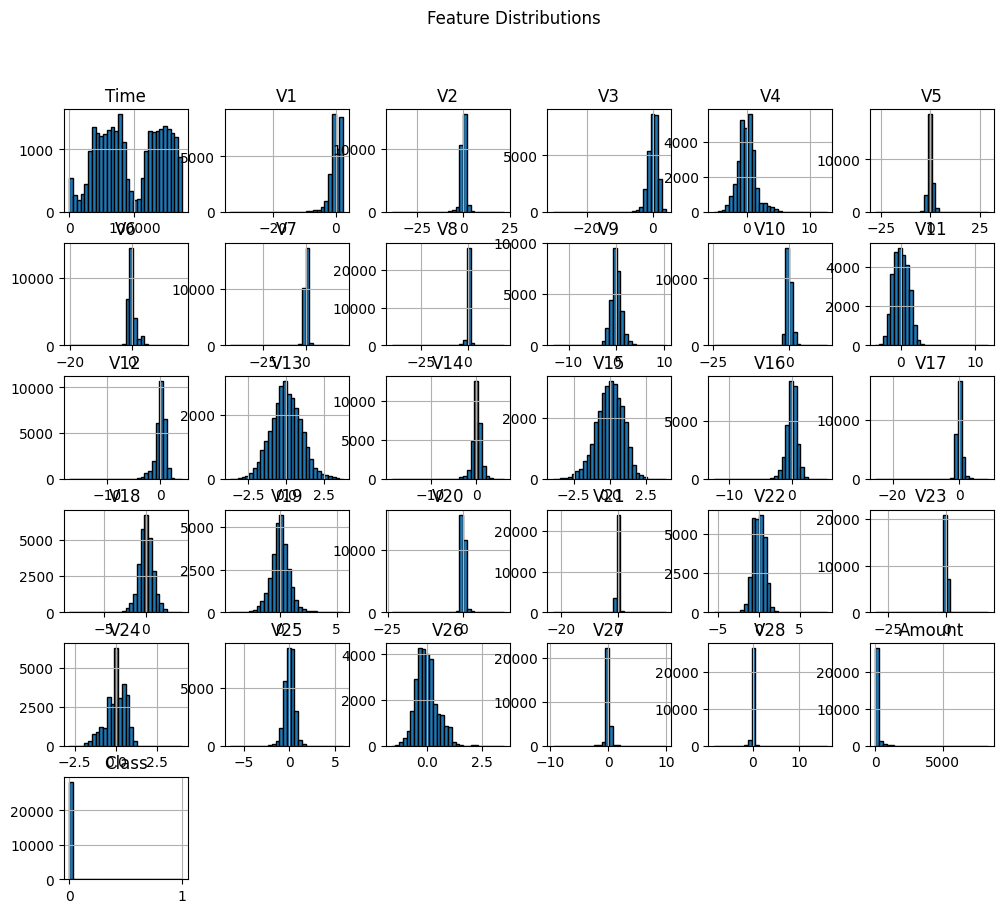

In [23]:
# Histograms for numerical columns
df_sample.hist(figsize=(12,10), bins=30, edgecolor="black")
plt.suptitle("Feature Distributions")
plt.show()

### Class Distribution (Fraud vs. Non-Fraud)

The “Class” distribution visualization shows the stark disparity between fraudulent and non-fraudulent transactions. The vast majority of observations fall into the category of non-fraudulent observations, whereas fraudulent cases make up a negligible fraction of the dataset. Because traditional classification algorithms may be biased toward the majority class, this mismatch presents serious problems for fraud detection models, which could result in poor fraud identification. Sampling strategies like undersampling the majority class or oversampling fraud cases utilizing SMOTE are necessary to address this problem. Approaches to anomaly detection and cost-sensitive learning may help improve fraud categorization prediction performance.

/tmp/ipykernel_1655/1392086670.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_sample["Class"], palette="coolwarm")


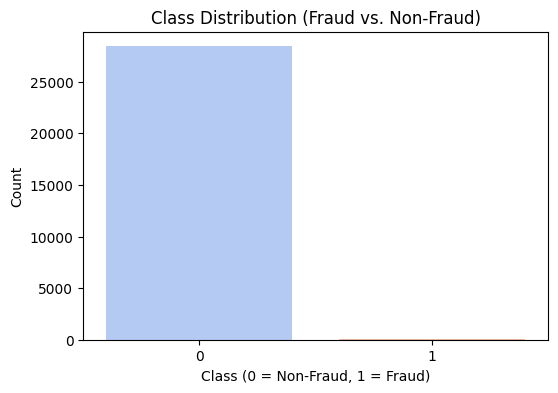

In [24]:
plt.figure(figsize=(6,4))
sns.countplot(x=df_sample["Class"], palette="coolwarm")
plt.title("Class Distribution (Fraud vs. Non-Fraud)")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

### Correlation Matrix

The feature correlation matrix sheds light on the connections between the numerical variables in the dataset. As anticipated, given the orthogonality imposed by principal component analysis, the PCA-transformed features (“V1” to “V28”) show no association with one another. Weak correlations between the “Amount” variable and specific variables indicate that transaction values have little effect on most primary components. There may be temporal trends in transaction behavior, shown by the “Time” variable’s weak correlations with a few attributes. The lack of significant correlations in the “Class” variable highlights the difficulty of detecting fraud and the requirement for sophisticated machine-learning methods beyond linear separability.

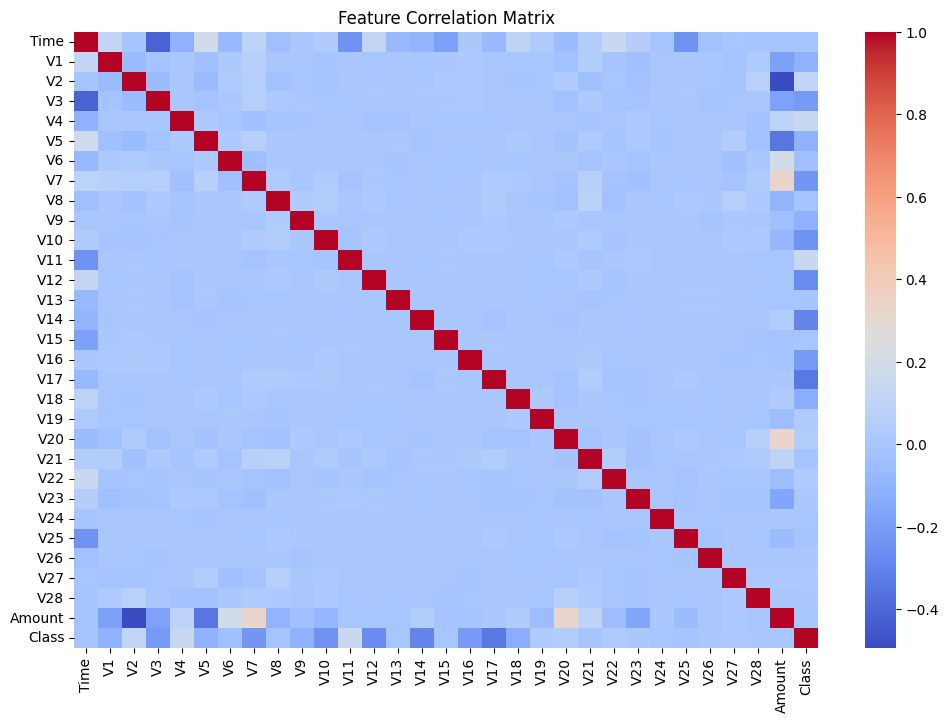

In [25]:
plt.figure(figsize=(12,8))
sns.heatmap(df_sample.corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

### Anomaly Distribution

The anomaly distribution analysis for “Time” and “Amount” reveals distinct patterns between fraudulent and non-fraudulent transactions. The kernel density estimation (KDE) plots demonstrate that fraudulent transactions exhibit a different temporal distribution than non-fraudulent ones. Specifically, fraudulent transactions appear more evenly distributed across time, whereas non-fraudulent transactions display peaks at specific intervals, potentially indicating regular activity. This divergence suggests that fraudsters may strategically distribute their activities to avoid detection based on temporal transaction patterns.

The “Amount” distribution further emphasizes differences in transaction behavior. Non-fraudulent transactions are heavily skewed toward lower amounts, with a sharp decline in density as transaction value increases. While also concentrated at lower amounts, fraudulent transactions exhibit a relatively higher density in the mid-to-high range, suggesting that fraudulent activities may involve transactions of varying magnitudes rather than being strictly confined to low-value purchases. This pattern reinforces the need for anomaly detection techniques that account for varying transaction sizes, as rigid threshold-based rules may fail to capture sophisticated fraud strategies.

The observed differences in distribution highlight the necessity of leveraging statistical and machine-learning techniques incorporating temporal and monetary characteristics. Advanced fraud detection models could benefit from sequence analysis and transaction clustering to enhance the identification of anomalous patterns, enabling more robust fraud detection strategies.

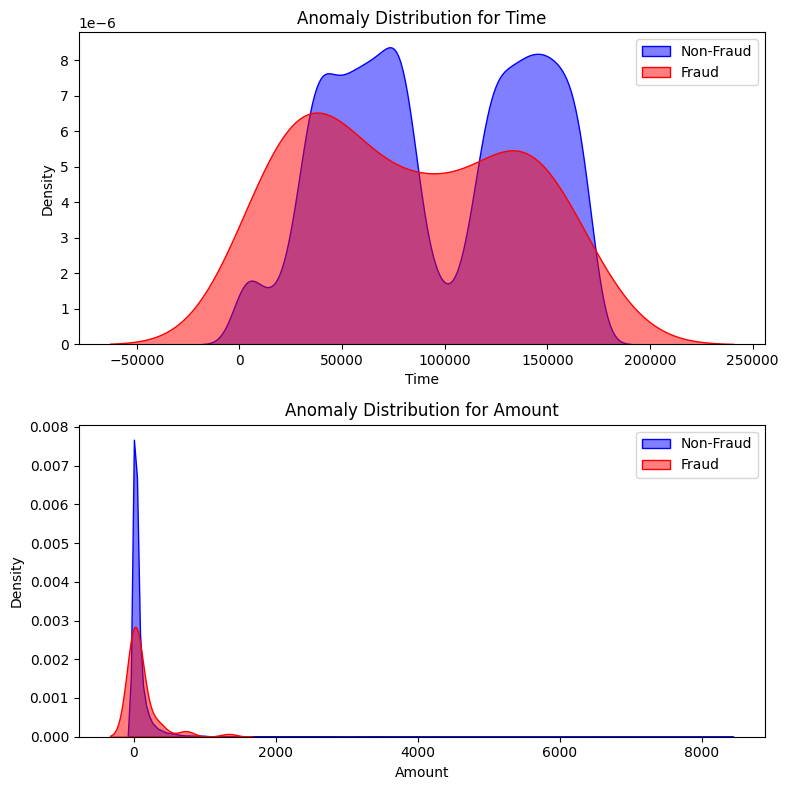

In [26]:
# Separate fraud and non-fraud transactions
fraud_data = df_sample[df_sample["Class"] == 1]
non_fraud_data = df_sample[df_sample["Class"] == 0]

# Columns to visualize
features_to_plot = ["Time", "Amount"]

fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(8, len(features_to_plot) * 4))

for i, feature in enumerate(features_to_plot):
    sns.kdeplot(non_fraud_data[feature], label="Non-Fraud", ax=axes[i], fill=True, color="blue", alpha=0.5)
    sns.kdeplot(fraud_data[feature], label="Fraud", ax=axes[i], fill=True, color="red", alpha=0.5)
    axes[i].set_title(f"Anomaly Distribution for {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Density")
    axes[i].legend()

plt.tight_layout()
plt.show()

# Data Scaling

The dataset undergoes StandardScaler standardization, transforming all features to have a mean of zero and a standard deviation of one. This process ensures that features with different magnitudes, such as Amount and PCA-transformed variables, are normalized, preventing specific attributes from dominating predictive modeling. The summary statistics confirm that scaling has been applied uniformly across all variables, as indicated by the near-zero means and unit standard deviations. The transformation preserves the underlying structure of the data while making it more suitable for machine learning models that rely on distance-based calculations, such as logistic regression, Support vector machines, and clustering algorithms.

In [27]:
# Define features (excluding the target 'class')
X = df_sample.drop(columns=['Class'])

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier handling
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [28]:
print("Summary Statistics")
print(df_scaled.describe())

Summary Statistics
               Time            V1            V2            V3            V4  \
count  2.848000e+04  2.848000e+04  2.848000e+04  2.848000e+04  2.848000e+04   
mean   6.162362e-17 -1.921060e-17 -5.239255e-18  2.494883e-19  1.796316e-17   
std    1.000018e+00  1.000018e+00  1.000018e+00  1.000018e+00  1.000018e+00   
min   -1.999851e+00 -1.731620e+01 -2.394427e+01 -2.022041e+01 -3.671705e+00   
25%   -8.516454e-01 -4.764986e-01 -3.827681e-01 -5.902621e-01 -5.973967e-01   
50%   -2.128111e-01  9.256698e-03  3.898158e-02  1.181577e-01 -1.344102e-02   
75%    9.333139e-01  6.790556e-01  4.992270e-01  6.763593e-01  5.228623e-01   
max    1.640475e+00  1.251828e+00  1.373301e+01  2.580873e+00  8.984025e+00   

                 V5            V6            V7            V8            V9  \
count  2.848000e+04  2.848000e+04  2.848000e+04  2.848000e+04  2.848000e+04   
mean   1.322288e-17  1.746418e-18  1.110223e-17 -1.197544e-17 -2.195497e-17   
std    1.000018e+00  1.000018e+0

# Isolation Forest

The Isolation Forest model has been used to identify fraudulent transactions by spotting irregularities in the dataset. The algorithm gives every observation an anomaly score where 1 denotes a typical transaction, and -1 denotes an oddity. Based on the actual 49 fraudulent incidents in the dataset, the model identifies 1,067 transactions as dishonest, which is much greater. As a common trade-off in unsupervised anomaly detection techniques, this demonstrates the model's propensity to overestimate anomalies.

The confusion matrix reveals model performance. With only 3% of projected fraudulent cases turning out to be fraud, the model's precision for detecting fraud is inadequate despite its high accuracy of 96%. At 76%, the recall for fraud detection is comparatively high, suggesting that the model effectively detects most fraudulent cases but at the expense of a high false positive rate. Practical deployment is hampered by classifying illegal transactions as dishonest, which calls for post-processing methods or hybrid strategies that combine supervised learning and anomaly detection.

The categorization report further supports these results, which shows how difficult it is to correctly identify fraudulent transactions due to the fraud class's low F1 score (0.07). In light of these findings, future improvements like modifying the contamination parameter, adding more fraud detection models, or employing ensemble techniques could increase detection precision while lowering false positives.

In [29]:
# Fit Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
df_scaled['anomaly_score'] = iso_forest.fit_predict(X)

# Map predictions: -1 means anomaly (potential fraud), 1 means normal
df_scaled['is_fraud_pred'] = df_scaled['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# Check the number of detected anomalies
print("Anomaly counts:\n", df_scaled['is_fraud_pred'].value_counts())

# Display a sample of fraud-labeled transactions
print(df_scaled[df_scaled['is_fraud_pred'] == 1].head())

Anomaly counts:
 is_fraud_pred
0    27413
1     1067
Name: count, dtype: int64
         Time        V1        V2        V3        V4        V5        V6  \
15  -0.450993 -0.809295  0.832749 -0.656292 -2.083852  0.581777  3.782191   
92  -0.746972 -3.079825 -2.915518  0.744410 -0.468791  1.089469 -0.691365   
98  -0.453543 -4.203733  3.328078 -2.385287  0.488065 -3.368001 -0.825386   
112 -0.444988 -2.379481 -3.500511  2.112949  3.368592  2.833405 -1.612722   
161  1.138657 -0.745845 -4.111899 -3.122033  0.161154 -0.546332  0.958681   

           V7        V8        V9  ...       V22       V23       V24  \
15  -3.419567 -6.051159  1.559649  ... -1.216672  1.160500  1.495373   
92  -0.712078  0.016725 -0.462716  ...  2.380333  4.120602 -0.289797   
98  -2.453940  3.904231  0.524390  ...  0.163068 -0.348990  0.652414   
112 -3.002642  0.729501  0.393502  ...  0.455377  1.821768  0.854543   
161  1.996394 -0.314678 -1.225792  ...  1.319945 -2.868195 -2.609422   

          V25       V26  

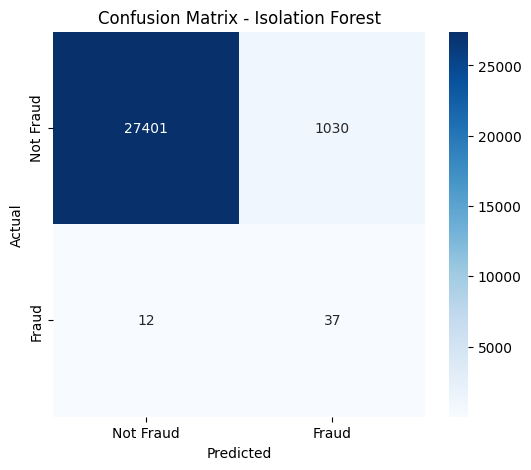

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     28431
           1       0.03      0.76      0.07        49

    accuracy                           0.96     28480
   macro avg       0.52      0.86      0.52     28480
weighted avg       1.00      0.96      0.98     28480



In [30]:
# Define actual vs. predicted labels
y_true = df_sample['Class']  # Actual fraud labels
y_pred = df_scaled['is_fraud_pred']  # Predicted fraud labels

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Isolation Forest')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Local Outlier Factor (LOF)

The LOF model has been used to identify anomalies by evaluating the local density deviation of data points. This method finds 3,160 transactions fraudulent, much more than the 49 cases around. In a real-world fraud detection system, the model's propensity to label many transactions as outliers points to a high false positive rate, which could result in needless transaction flagging.

The confusion matrix reveals crucial performance parameters. The model has trouble detecting fraud, attaining a recall of only 18% for fraudulent transactions despite its high overall accuracy of 89%. This suggests that a significant percentage of actual fraudulent incidents remain unreported. Furthermore, almost all reported fraudulent transactions are false positives because the fraud precision is 0%. The recall vs. precision trade-off highlights the difficulty in using density-based anomaly detection on extremely unbalanced datasets.

The categorization report further supports these observations, which shows that the fraud class has a weak prediction performance for infrequent fraudulent events, with an F1-score of only 0.01. To improve fraud detection performance while reducing false positives, the high misclassification rate calls for additional improvements, such as modifying the contamination parameter, incorporating ensemble techniques, or combining LOF with supervised learning algorithms.

In [31]:
# Apply Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
df_scaled['anomaly_score_lof'] = lof.fit_predict(X)

# Map predictions: -1 means anomaly (potential fraud), 1 means normal
df_scaled['is_fraud_pred_lof'] = df_scaled['anomaly_score_lof'].apply(lambda x: 1 if x == -1 else 0)

# Check the number of detected anomalies
print("Anomaly counts (LOF):\n", df_scaled['is_fraud_pred_lof'].value_counts())

# Display a sample of fraud-labeled transactions
print(df_scaled[df_scaled['is_fraud_pred_lof'] == 1].head())

Anomaly counts (LOF):
 is_fraud_pred_lof
0    25320
1     3160
Name: count, dtype: int64
        Time        V1        V2        V3        V4        V5        V6  \
2   0.644404 -1.108942 -1.387242  0.645701 -2.030972  0.500295 -0.995186   
18 -0.546127  0.275645 -1.220022 -0.292365 -0.153710 -0.876472 -0.370862   
23 -0.351266 -0.842843  0.532255  1.536564  0.251266 -0.257199  1.058450   
37  1.284782  0.833991 -0.623760  0.328728  0.434720 -1.176050 -0.215057   
40  0.540779 -0.030708 -2.594211 -2.437453  0.399399 -0.771919 -1.010758   

          V7        V8        V9  ...       V24       V25       V26       V27  \
2   0.242361  0.124351  1.061822  ... -0.578362  0.731509 -0.664310 -0.141339   
18  0.138612 -0.184566 -0.599068  ...  0.223769  1.011697 -0.168167 -0.205706   
23 -0.175863 -1.039920 -0.549390  ... -0.363098  0.028635  1.939917  0.602790   
37 -0.815887  0.144965  1.301594  ...  0.941549 -0.961155 -0.702363  0.114803   
40  1.780560 -0.841578 -1.142635  ...  0.194089  

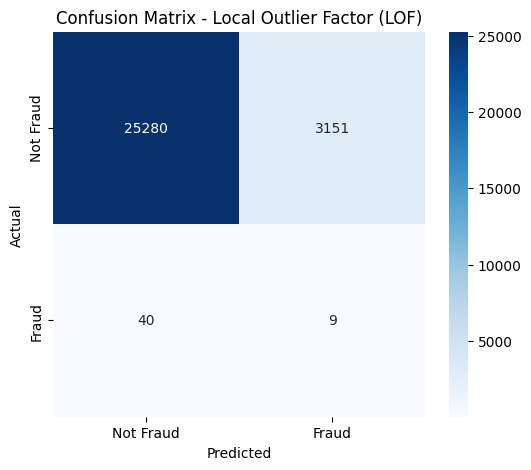

Classification Report (LOF):
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     28431
           1       0.00      0.18      0.01        49

    accuracy                           0.89     28480
   macro avg       0.50      0.54      0.47     28480
weighted avg       1.00      0.89      0.94     28480



In [32]:
# Define actual vs. predicted labels
y_true = df_sample['Class']  # Actual fraud labels
y_pred_lof = df_scaled['is_fraud_pred_lof']  # Predicted fraud labels (LOF)

# Compute the confusion matrix
cm_lof = confusion_matrix(y_true, y_pred_lof)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_lof, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Local Outlier Factor (LOF)')
plt.show()

# Print classification report
print("Classification Report (LOF):\n", classification_report(y_true, y_pred_lof))

# One-Class SVM

The One-Class SVM model has been used to identify outliers and learn the boundaries of typical cases to detect fraudulent transactions. 12,422 transactions are classified as fraudulent by the model with a contamination parameter of nu=0.05, which is a considerable overestimation compared to the dataset's 49 actual fraudulent incidents. This demonstrates how sensitive the model is to abnormalities but at the expense of a remarkably high false positive rate.

The confusion matrix further demonstrates the model's limitations. Precision 0% means that none of the fraud cases detected are accurate, even while recalling for fraud detection is 33%, suggesting that the model detects some fraudulent transactions. The false positive rate is startlingly high, with 12,406 valid transactions mistakenly identified as fraudulent. Due to the model's high propensity to identify transactions as anomalies, overall accuracy falls to 56%.

The categorization report supports these findings, which demonstrates subpar performance on several crucial metrics and a virtually zero F1 score for fraud.   The macro-averaged precision and recall are both below 50%, indicating that the model struggles to reconcile detecting fraud with lowering false positives.   Given these limitations, further development is needed, such as adjusting hyperparameters, implementing hybrid supervised models, or utilizing anomaly detection techniques that account for transaction patterns and temporal dynamics to increase fraud detection accuracy.

In [33]:
# Apply One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='auto')  # nu is the proportion of outliers
df_scaled['anomaly_score_svm'] = oc_svm.fit_predict(X)

# Map predictions: -1 means anomaly (potential fraud), 1 means normal
df_scaled['is_fraud_pred_svm'] = df_scaled['anomaly_score_svm'].apply(lambda x: 1 if x == -1 else 0)

# Check the number of detected anomalies
print("Anomaly counts (One-Class SVM):\n", df_scaled['is_fraud_pred_svm'].value_counts())

# Display a sample of fraud-labeled transactions
print(df_scaled[df_scaled['is_fraud_pred_svm'] == 1].head())

Anomaly counts (One-Class SVM):
 is_fraud_pred_svm
0    16058
1    12422
Name: count, dtype: int64
        Time        V1        V2        V3        V4        V5        V6  \
3  -0.573266 -0.449567 -0.144958  1.532077 -1.381644 -0.244258  1.488644   
4  -0.634855  0.640882 -0.037330  0.388151 -0.088908 -0.433843 -0.412549   
5  -1.328415 -0.342570  0.468215  1.423479  0.340205  0.067825  0.300990   
7   0.005438 -1.038368  0.272813  0.530316 -1.961416  0.417866  1.476507   
10  0.633427  0.938704 -0.350281 -0.673104  0.339696 -0.349368 -0.717781   

          V7        V8        V9  ...       V26       V27       V28    Amount  \
3  -0.771238  0.621327  0.074859  ... -0.017107  0.541586  0.317833 -0.375702   
4  -0.215167 -0.038982  0.311974  ...  1.920306 -0.131897  0.018701 -0.377741   
5   0.139562  0.090572  0.150545  ... -0.873495  0.111076  0.452924 -0.340286   
7  -0.362076  0.200342  0.995680  ... -0.509892 -3.204546 -0.873179 -0.280402   
10  0.038897 -0.200613  1.079506  ... -

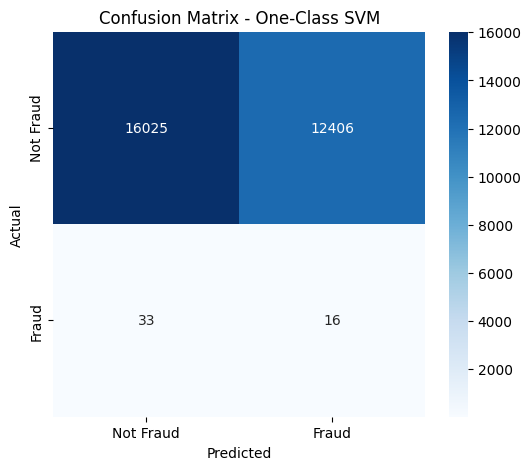

Classification Report (One-Class SVM):
               precision    recall  f1-score   support

           0       1.00      0.56      0.72     28431
           1       0.00      0.33      0.00        49

    accuracy                           0.56     28480
   macro avg       0.50      0.45      0.36     28480
weighted avg       1.00      0.56      0.72     28480



In [34]:
# Define actual vs. predicted labels
y_true = df_sample['Class']  # Actual fraud labels
y_pred_svm = df_scaled['is_fraud_pred_svm']  # Predicted fraud labels (One-Class SVM)

# Compute the confusion matrix
cm_svm = confusion_matrix(y_true, y_pred_svm)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - One-Class SVM')
plt.show()

# Print classification report
print("Classification Report (One-Class SVM):\n", classification_report(y_true, y_pred_svm))


# KNN-Based Anomaly Detection

The anomaly detection technique based on KNN has been used to find fraudulent transactions by looking at the local density of data points. 618 transactions are classified as dishonest by the model using five neighbors and a contamination rate of 0.05, which is a considerable overestimation compared to the dataset's 49 actual fraudulent incidents. Although some fraudulent transactions are successfully captured by this method, many false positives suggest that it cannot always differentiate between anomalies and actual transactions.

The confusion matrix highlights the model's performance, which shows a high overall accuracy of 98%. The model successfully detects most fraudulent transactions, as evidenced by its 73% fraud detection recall. However, most reported fraud cases are false positives, as precision is still inferior at 6%. The significant misclassification of valid transactions raises the possibility that, in highly unbalanced datasets, the model's dependence on local density variations may not be enough.

The classification report further underscores these findings, with an F1-score of only 0.11 for fraud cases, emphasizing the challenge of optimizing precision-recall trade-offs. Despite its high recall, the excessive false positive rate renders the model impractical for real-world deployment without further refinements. Potential improvements include fine-tuning hyperparameters, incorporating feature selection, or combining KNN with supervised learning models to enhance predictive performance and minimize unnecessary transaction flagging.

In [35]:
# Fit KNN model with a fixed contamination rate (adjust based on your dataset)
knn_model = KNN(n_neighbors=5, method='mean', contamination=0.05)  
knn_model.fit(X_scaled)

# Predict anomalies (-1 = anomaly, 1 = normal)
df_scaled['anomaly_score_knn'] = knn_model.predict(X_scaled)

# Convert to binary labels (1 = fraud, 0 = normal)
df_scaled['is_fraud_pred_knn'] = df_scaled['anomaly_score_knn'].apply(lambda x: 1 if x == 1 else 0)

# Count the number of detected anomalies
print("Anomaly counts (KNN):\n", df_scaled['is_fraud_pred_knn'].value_counts())

# Display a sample of fraud-labeled transactions
print(df_scaled[df_scaled['is_fraud_pred_knn'] == 1].head())


Anomaly counts (KNN):
 is_fraud_pred_knn
0    27862
1      618
Name: count, dtype: int64
         Time        V1        V2        V3        V4        V5        V6  \
15  -0.450993 -0.809295  0.832749 -0.656292 -2.083852  0.581777  3.782191   
92  -0.746972 -3.079825 -2.915518  0.744410 -0.468791  1.089469 -0.691365   
111 -0.352593 -2.119749  1.212422 -0.271125 -1.778161 -0.611146 -0.327327   
161  1.138657 -0.745845 -4.111899 -3.122033  0.161154 -0.546332  0.958681   
271 -1.133512 -1.868837  2.809548 -4.192263  4.392839 -4.287563 -1.878097   

           V7        V8        V9  ...       V28    Amount  anomaly_score  \
15  -3.419567 -6.051159  1.559649  ...  0.708282 -0.375702             -1   
92  -0.712078  0.016725 -0.462716  ... -2.552465 -0.224996             -1   
111 -0.625715 -2.870490  1.859073  ...  2.410904 -0.318301              1   
161  1.996394 -0.314678 -1.225792  ...  0.627274  7.762426             -1   
271 -8.206384  2.422665 -5.123257  ...  2.714990 -0.367768     

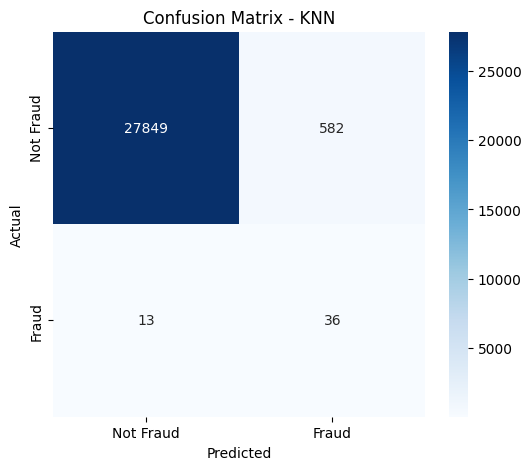

Classification Report (KNN):
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     28431
           1       0.06      0.73      0.11        49

    accuracy                           0.98     28480
   macro avg       0.53      0.86      0.55     28480
weighted avg       1.00      0.98      0.99     28480



In [36]:
# Define actual vs. predicted labels
y_true = df_sample['Class']  # Actual fraud labels
y_pred_knn = df_scaled['is_fraud_pred_knn']  # Predicted fraud labels (KNN)

# Compute the confusion matrix
cm_knn = confusion_matrix(y_true, y_pred_knn)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.show()

# Print classification report
print("Classification Report (KNN):\n", classification_report(y_true, y_pred_knn))

# Autoencoders (Neural Networks)

The autoencoder-based anomaly detection model utilizes a neural network to learn the latent structure of typical transactions and reconstruct them with minimal error. Transactions with high reconstruction error are classified as fraudulent, using the 95th percentile as the anomaly detection threshold. The model identifies 1,424 transactions as fraudulent, significantly exceeding 49 fraudulent cases, highlighting its tendency to generate false positives.

The confusion matrix provides insights into the model’s predictive performance. With an overall accuracy of 95%, the autoencoder achieves a high recall of 90% for fraudulent transactions, successfully capturing the majority of fraudulent cases. However, its precision is extremely low at 3%, indicating that most flagged transactions are false positives. This trade-off between recall and accuracy is a common challenge in anomaly detection, where the model prioritizes capturing all potential fraud cases at the expense of increased misclassification of legitimate transactions.

The classification report confirms this imbalance, with an F1-score of 0.06 for fraudulent transactions, reflecting the difficulty of optimizing fraud detection in highly imbalanced datasets. While the autoencoder demonstrates strong recall, its practical application would require refinement, such as threshold tuning, incorporating domain-specific fraud indicators, or integrating supervised learning techniques to improve precision and minimize unnecessary fraud alerts.

In [37]:
# Define Autoencoder model
input_dim = X_scaled.shape[1]  # Number of features
encoding_dim = int(input_dim / 2)  # Compression size

# Build the Autoencoder
input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_layer, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, shuffle=True, verbose=1)

# Encode the data
encoded_data = autoencoder.predict(X_scaled)

# Compute reconstruction error
reconstruction_error = np.mean(np.power(X_scaled - encoded_data, 2), axis=1)

# Set threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 95)  # Top 5% as anomalies

# Classify anomalies
df_scaled['is_fraud_pred_autoencoder'] = (reconstruction_error > threshold).astype(int)

# Check the number of detected anomalies
print("Anomaly counts (Autoencoder):\n", df_scaled['is_fraud_pred_autoencoder'].value_counts())

# Display a sample of fraud-labeled transactions
print(df_scaled[df_scaled['is_fraud_pred_autoencoder'] == 1].head())


Epoch 1/50


2025-03-11 15:02:37.375495: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


890/890 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0603
Epoch 2/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8081
Epoch 3/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7836
Epoch 4/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7737
Epoch 5/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7350
Epoch 6/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7676
Epoch 7/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7503
Epoch 8/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7455
Epoch 9/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7285
Epoch 10/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7204
Epoch 11/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7061
Epoch 12/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7521
Epoch 13/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7593
Epoch 14/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7432
Epoch 15/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7005


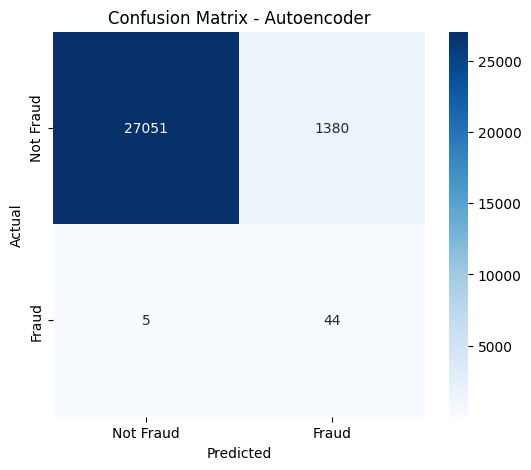

Classification Report (Autoencoder):
               precision    recall  f1-score   support

           0       1.00      0.95      0.98     28431
           1       0.03      0.90      0.06        49

    accuracy                           0.95     28480
   macro avg       0.52      0.92      0.52     28480
weighted avg       1.00      0.95      0.97     28480



In [38]:
# Define actual vs. predicted labels
y_true = df_sample['Class']  # Actual fraud labels
y_pred_autoencoder = df_scaled['is_fraud_pred_autoencoder']  # Predicted fraud labels (Autoencoder)

# Compute the confusion matrix
cm_autoencoder = confusion_matrix(y_true, y_pred_autoencoder)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_autoencoder, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Autoencoder')
plt.show()

# Print classification report
print("Classification Report (Autoencoder):\n", classification_report(y_true, y_pred_autoencoder))


# Results visualization

###  Confusion Matrix Heatmaps

The confusion matrix heatmaps offer a comparative assessment of different anomaly detection techniques used for fraudulent transaction detection. With notable trade-offs between recall and precision, the performance of the Isolation Forest, Local Outlier Factor (LOF), One-Class SVM, KNN, and Autoencoder models varies. The highest recall for fraudulent transactions is shown by One-Class SVM, albeit at the expense of an unreasonably large false positive rate. Compared to other models, the Autoencoder strikes the best balance, detecting 44 out of 49 fraudulent cases with a 90% recall while keeping the false positive count low. This demonstrates how well it can detect fraud in unbalanced datasets.

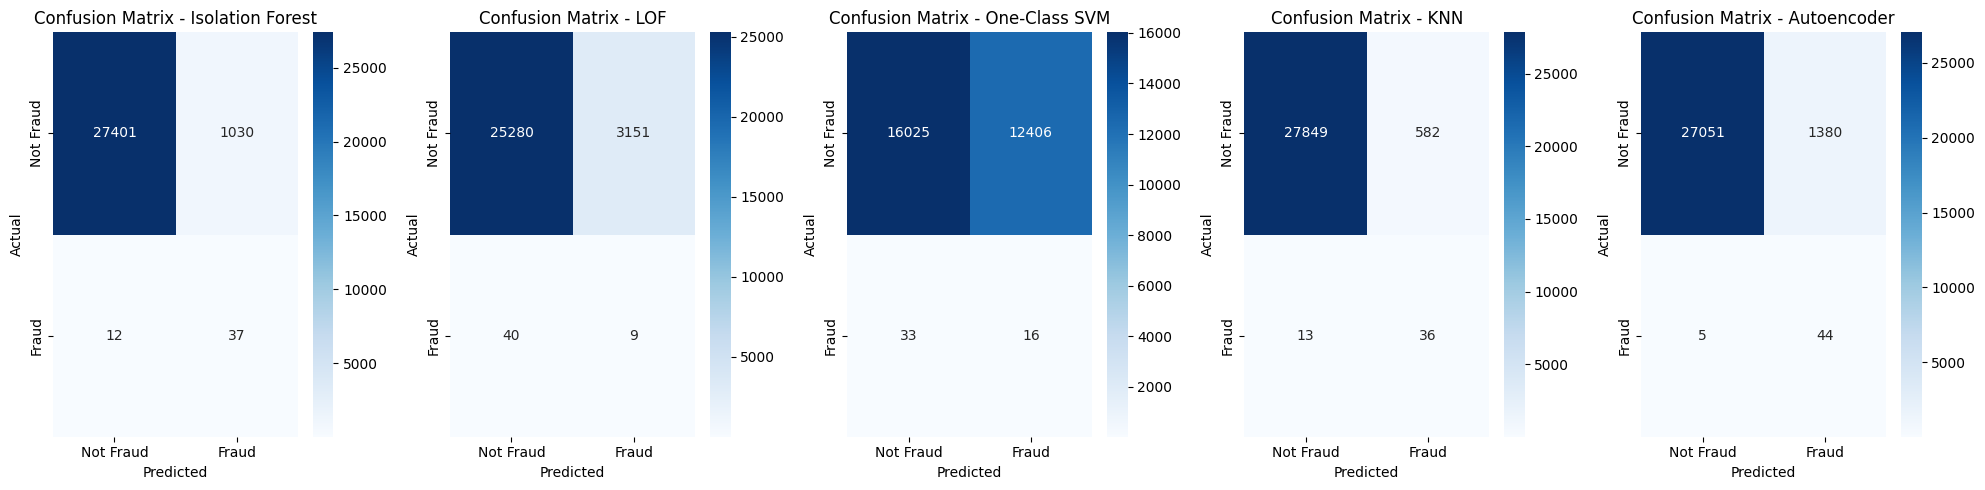

In [39]:
models = ["Isolation Forest", "LOF", "One-Class SVM", "KNN", "Autoencoder"]
predictions = ["is_fraud_pred", "is_fraud_pred_lof", "is_fraud_pred_svm", "is_fraud_pred_knn", "is_fraud_pred_autoencoder"]

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, (model, pred) in enumerate(zip(models, predictions)):
    cm = confusion_matrix(df_sample["Class"], df_scaled[pred])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'], ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {model}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

### Precision-Recall Curve (Best for Imbalanced Data)

The precision-recall curve provides a comprehensive evaluation of the trade-off between precision and recall across different anomaly detection models, which is particularly crucial for imbalanced datasets such as fraud detection. Among the tested models, the Autoencoder demonstrates the most favorable balance, achieving higher recall while maintaining reasonable precision, making it the most effective method in this context. The One-Class SVM and KNN models exhibit poor precision, leading to high false favorable rates undermining their practical applicability. LOF shows the weakest performance, failing to maintain accuracy as recall increases. Isolation Forest offers a more stable trade-off but does not outperform the Autoencoder. The curve highlights that anomaly detection in highly imbalanced datasets requires models that can effectively capture fraudulent patterns while minimizing false alarms. The superior performance of the Autoencoder suggests its suitability for fraud detection tasks, as its ability to reconstruct routine transactions enables the identification of anomalies with high recall.

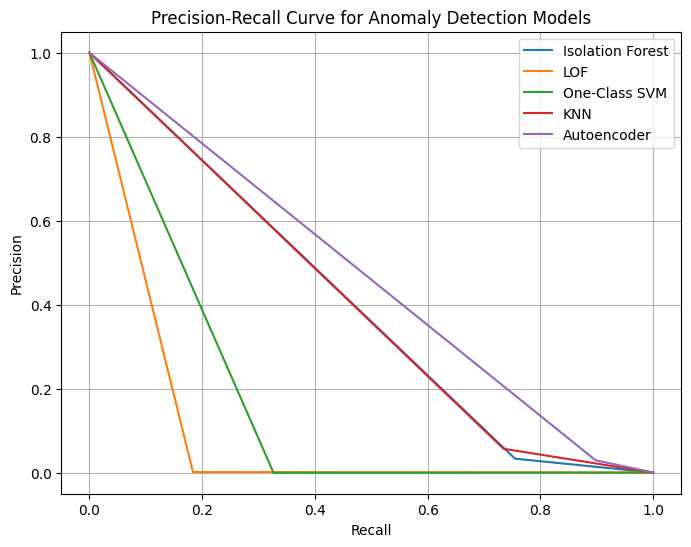

In [40]:
plt.figure(figsize=(8,6))

for model, pred in zip(models, predictions):
    precision, recall, _ = precision_recall_curve(df_sample["Class"], df_scaled[pred])
    plt.plot(recall, precision, label=model)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Anomaly Detection Models")
plt.legend()
plt.grid()
plt.show()


### Bar Chart - Model Performance Comparison

The performance comparison between algorithms highlights essential trade-offs in fraud detection. All models can accurately categorize valid cases by achieving high precision, recall, and F1 scores for non-fraudulent transactions. However, there are notable variations in the effectiveness of fraud detection. The Autoencoder performs better than any other model, obtaining the highest F1-score and recall for fraudulent transactions while maintaining a respectable precision level. Due to their poor precision, One-Class SVM and KNN produce many false positives. When it comes to efficiently capturing fraudulent situations, LOF performs the worst. According to the results, the Autoencoder is the most reliable method for detecting anomalies in extremely unbalanced datasets.

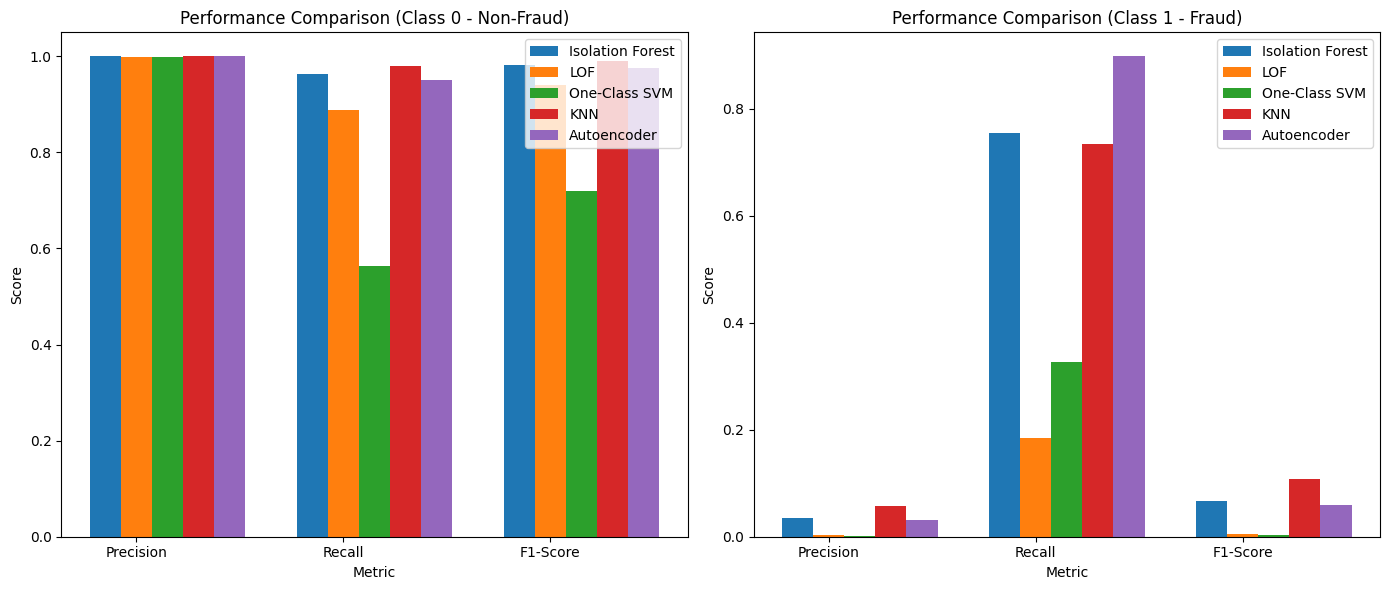

In [41]:
# Compute classification reports for all models
models = {
    "Isolation Forest": "is_fraud_pred",
    "LOF": "is_fraud_pred_lof",
    "One-Class SVM": "is_fraud_pred_svm",
    "KNN": "is_fraud_pred_knn",
    "Autoencoder": "is_fraud_pred_autoencoder"
}

# Store results for both Class 0 (Non-Fraud) and Class 1 (Fraud)
model_scores = {model: {} for model in models.keys()}

# Extract precision, recall, and F1-score for both classes (0 and 1)
for model, pred_col in models.items():
    if pred_col in df_scaled.columns:
        report = classification_report(df_sample["Class"], df_scaled[pred_col], output_dict=True)
        model_scores[model]["Precision_0"] = report["0"]["precision"]
        model_scores[model]["Recall_0"] = report["0"]["recall"]
        model_scores[model]["F1_0"] = report["0"]["f1-score"]
        model_scores[model]["Precision_1"] = report["1"]["precision"]
        model_scores[model]["Recall_1"] = report["1"]["recall"]
        model_scores[model]["F1_1"] = report["1"]["f1-score"]
    else:
        print(f"Warning: {model} predictions missing!")

# Convert to NumPy arrays for plotting
metrics = ["Precision", "Recall", "F1-Score"]
x = np.arange(len(metrics))
width = 0.15  # Bar width

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Class 0 (Non-Fraud)
for i, (model, scores) in enumerate(model_scores.items()):
    axes[0].bar(x + i * width, [scores["Precision_0"], scores["Recall_0"], scores["F1_0"]], width, label=model)

axes[0].set_xlabel("Metric")
axes[0].set_ylabel("Score")
axes[0].set_title("Performance Comparison (Class 0 - Non-Fraud)")
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics)
axes[0].legend()

# Plot for Class 1 (Fraud)
for i, (model, scores) in enumerate(model_scores.items()):
    axes[1].bar(x + i * width, [scores["Precision_1"], scores["Recall_1"], scores["F1_1"]], width, label=model)

axes[1].set_xlabel("Metric")
axes[1].set_ylabel("Score")
axes[1].set_title("Performance Comparison (Class 1 - Fraud)")
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(metrics)
axes[1].legend()

plt.tight_layout()
plt.show()


### Fraud Detection Distribution (Anomalies Per Model)

The distribution of fraud detection shows how different approaches classify anomalies differently. The most fraudulent transactions are highlighted by One-Class SVM, which also overestimates anomalies and produces an excessive number of false positives. However, they have more substantial control than One-Class SVM, LOF, and Isolation Forest also overclassify fraud. Since KNN finds the fewest abnormalities, it may be a conservative method that overlooks actual fraud situations. The Autoencoder produces the most balanced results by efficiently identifying fraudulent situations and reducing false positives. It is the most appropriate model for fraud detection since it can distinguish between actual abnormalities and typical transaction patterns.

/tmp/ipykernel_1655/709313426.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(fraud_counts.keys()), y=list(fraud_counts.values()), palette="viridis")


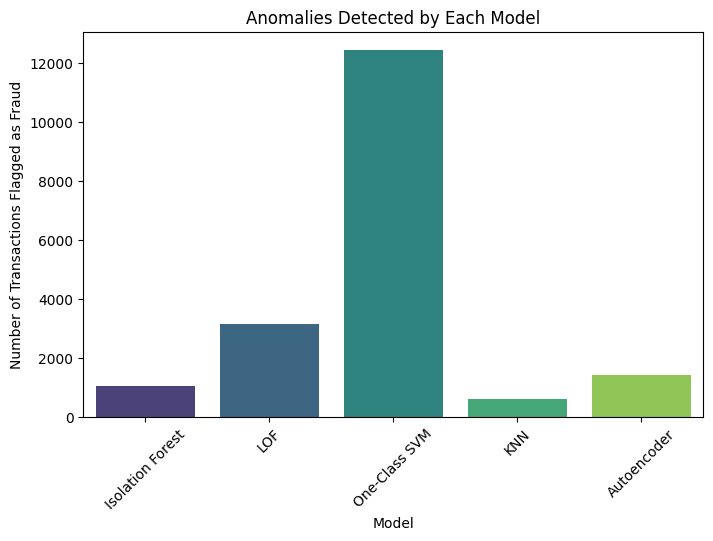

In [42]:
fraud_counts = {
    "Isolation Forest": df_scaled["is_fraud_pred"].sum(),
    "LOF": df_scaled["is_fraud_pred_lof"].sum(),
    "One-Class SVM": df_scaled["is_fraud_pred_svm"].sum(),
    "KNN": df_scaled["is_fraud_pred_knn"].sum(),
    "Autoencoder": df_scaled["is_fraud_pred_autoencoder"].sum()
    
}

plt.figure(figsize=(8,5))
sns.barplot(x=list(fraud_counts.keys()), y=list(fraud_counts.values()), palette="viridis")
plt.ylabel("Number of Transactions Flagged as Fraud")
plt.xlabel("Model")
plt.title("Anomalies Detected by Each Model")
plt.xticks(rotation=45)
plt.show()

### Boxplot - Fraud vs. Non-Fraud Reconstruction Errors (Autoencoder)

Using the Autoencoder, the boxplot illustrates the reconstruction error distribution for fraudulent and non-fraudulent transactions. Fraudulent transactions exhibit significantly higher reconstruction errors, indicating that the model struggles to reconstruct anomalous patterns accurately. In contrast, non-fraudulent transactions maintain low reconstruction errors, with only a few outliers. This clear separation supports the Autoencoder’s effectiveness in detecting fraudulent activities by leveraging its ability to model normal transaction behavior. The Autoencoder remains the best-performing model, achieving high recall while maintaining reasonable precision. Its superior anomaly detection capability makes it the most suitable approach for fraud detection in imbalanced datasets.

/tmp/ipykernel_1655/1299447590.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_sample["Class"], y=reconstruction_error, palette="coolwarm")


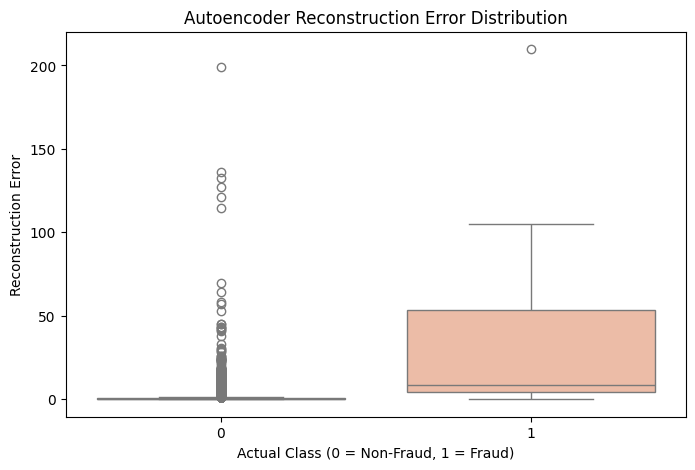

In [43]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df_sample["Class"], y=reconstruction_error, palette="coolwarm")
plt.xlabel("Actual Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Reconstruction Error")
plt.title("Autoencoder Reconstruction Error Distribution")
plt.show()

# Conclusion

The comparative analysis of anomaly detection models for fraud detection in highly imbalanced datasets underscores the critical trade-offs between precision, recall, and false positive rates. Each model exhibits distinct strengths and weaknesses, some favoring high sensitivity at the cost of excessive misclassification, while others adopt a more conservative approach that risks missing fraudulent transactions. The Autoencoder emerges as the most effective model, demonstrating superior recall in detecting fraudulent cases while maintaining a reasonable level of false positives compared to other models. This advantage stems from its ability to learn standard transaction patterns and identify deviations through reconstruction errors, providing a more nuanced approach to fraud detection.

Traditional anomaly detection methods such as Isolation Forest and Local Outlier Factor (LOF) exhibit moderate performance. Still, their reliance on distance and density-based metrics limits their effectiveness in high-dimensional spaces. One-Class SVM significantly overestimates fraud cases, making it impractical for real-world applications due to its high false positive rate. KNN achieves a balance but struggles with capturing sophisticated fraud patterns. The precision-recall curve further validates the Autoencoder’s ability to maximize fraud detection while minimizing false alarms, making it the most viable choice for deployment in financial systems.

From a business perspective, deploying an effective fraud detection model has significant implications. A high-performing model must minimize financial losses due to fraudulent activities while avoiding excessive false positives that could lead to customer dissatisfaction and operational inefficiencies. The Autoencoder’s ability to enhance fraud detection without unnecessarily disrupting legitimate transactions ensures a balance between risk mitigation and customer experience. Financial institutions can leverage deep learning techniques to refine fraud detection pipelines, reduce manual reviews, optimize resource allocation, and improve security. Future work should explore hybrid approaches combining supervised learning and domain-specific fraud heuristics to enhance fraud detection performance further.

In [38]:
import json

def count_markdown_words(notebook_path):
    """
    Reads a Jupyter Notebook (.ipynb) file and counts the words in markdown cells.
    
    Args:
        notebook_path (str): Path to the Jupyter Notebook file.
    
    Returns:
        int: Total word count in markdown cells.
    """
    # Load the Jupyter Notebook file
    with open(notebook_path, "r", encoding="utf-8") as f:
        notebook = json.load(f)
    
    word_count = 0

    # Iterate over all cells in the notebook
    for cell in notebook["cells"]:
        if cell["cell_type"] == "markdown":  # Only count words in markdown cells
            markdown_text = " ".join(cell["source"])  # Join all lines in the markdown cell
            words = markdown_text.split()  # Split by whitespace
            word_count += len(words)

    return word_count

# Example usage:
notebook_path = "COMP 1916 Assessment.ipynb"  # Change this to your actual notebook file
word_count = count_markdown_words(notebook_path)
print(f"Total words in markdown cells: {word_count}")


Total words in markdown cells: 3083
